<a href="https://colab.research.google.com/github/ucok-man/analisis-sentimen-review-aplikasi-SIREKAP-KPU/blob/main/Analisis_Sentimen_Review_Aplikasi_SIREKAP_KPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Langkah 2: Install Library yang Dibutuhkan

**Penjelasan:**
Install library yang diperlukan untuk scraping data dari Play Store, pemrosesan teks Bahasa Indonesia, dan analisis sentimen. Library `google-play-scraper` untuk mengambil review, `Sastrawi` untuk stemming Bahasa Indonesia, dan `nltk` untuk pemrosesan teks.

In [45]:
!pip install google-play-scraper
!pip install pymongo
!pip install Sastrawi
!pip install nltk
!pip install wordcloud
!pip install pandarallel
!pip install seaborn

### Langkah 3: Import Library

**Penjelasan:**
Import semua library yang akan digunakan dalam project ini. Library-library ini mencakup tools untuk scraping, manipulasi data, pemrosesan teks, machine learning, dan visualisasi.

In [17]:
from google_play_scraper import app, Sort, reviews_all
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download resource NLTK
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/ucok/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ucok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Langkah 4: Scraping Review dari Play Store

**Penjelasan:**
Lakukan scraping untuk mengumpulkan semua review aplikasi SIREKAP KPU dari Google Play Store. ID aplikasi adalah `id.go.kpu.sirekap2024`. Parameter `lang='id'` dan `country='id'` memastikan kita mendapatkan review dari pengguna Indonesia dalam Bahasa Indonesia.

In [18]:
# Scraping semua review
app_id = "id.go.kpu.sirekap2024"
result = reviews_all(
    app_id,
    sleep_milliseconds=0,
    lang='id',              # Bahasa Indonesia
    country='id',           # Negara Indonesia
    sort=Sort.NEWEST        # Urut berdasarkan terbaru
)

print(f"Berhasil mengumpulkan {len(result)} review")

Berhasil mengumpulkan 21570 review


### Langkah 5: Konversi ke DataFrame

**Penjelasan:**
Ubah hasil scraping yang berupa list of dictionaries menjadi pandas DataFrame agar lebih mudah dimanipulasi dan dianalisis. DataFrame menyediakan struktur tabular yang memudahkan operasi data.

In [19]:
# Ubah hasil scraping ke DataFrame
df = pd.DataFrame(result)

# Tampilkan 5 data pertama
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,9e7cfde1-4707-4ba9-b4f6-b1c46053063c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Pastikan disiapkan jauh² hari, jangan sudah wa...",1,0,None,2025-09-03 11:01:10,None,None,None
1,fb13a1a8-ac62-4964-aedc-ac206ff72f11,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,saya iqba bagus baget wak :v,4,0,None,2025-05-05 16:02:11,None,None,None
2,f3b7208e-357d-4d77-bbad-ef7f8f660efa,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,susah,4,0,None,2025-04-11 21:01:31,None,None,None
3,f70062bd-2bd3-4548-b79e-f669e8957993,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,kenapa yah kok aplikasi nya sudah tidak dapat ...,1,2,2.73,2025-04-10 06:09:47,None,None,2.73
4,e3032f2b-f222-4cb8-b94e-47f6c4f6aaea,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,sangat luar biasa,5,0,None,2025-04-09 18:01:01,None,None,None


### Langkah 6: Filter dan Urutkan Data

**Penjelasan:**
Dari semua kolom yang tersedia, kita hanya memerlukan kolom `userName` (nama pengguna), `score` (rating 1-5), `at` (tanggal review), dan `content` (isi review). Data kemudian diurutkan berdasarkan tanggal terbaru agar review terkini muncul di atas.

In [20]:
# Ambil kolom penting untuk analisis
df_clean = df[['userName', 'score', 'at', 'content']].copy()

# Urutkan berdasarkan tanggal terbaru
df_clean = df_clean.sort_values(by='at', ascending=False)

# Reset index
df_clean = df_clean.reset_index(drop=True)

print(f"Total review: {len(df_clean)}")
df_clean.head()


Total review: 21570


,userName,score,at,content
0,Pengguna Google,1,2025-09-03 11:01:10,"Pastikan disiapkan jauh² hari, jangan sudah wa..."
1,Pengguna Google,4,2025-05-05 16:02:11,saya iqba bagus baget wak :v
2,Pengguna Google,4,2025-04-11 21:01:31,susah
3,Pengguna Google,1,2025-04-10 06:09:47,kenapa yah kok aplikasi nya sudah tidak dapat ...
4,Pengguna Google,5,2025-04-09 18:01:01,sangat luar biasa


### Langkah 7: Buat Label Sentimen

**Penjelasan:**
Buat label sentimen berdasarkan rating yang diberikan pengguna. Rating 1-2 dikategorikan sebagai **Negatif**, rating 3 sebagai **Netral**, dan rating 4-5 sebagai **Positif**. Fungsi `pelabelan()` akan otomatis mengklasifikasikan setiap review.

In [21]:
def pelabelan(score):
    if score <= 2:
        return "Negatif"
    elif score == 3:
        return "Netral"
    else:
        return "Positif"

# Terapkan pelabelan
df_clean['Label'] = df_clean['score'].apply(pelabelan)

# Tampilkan distribusi label
print(df_clean['Label'].value_counts())
df_clean.head(10)

Label
Negatif    16223
Positif     4268
Netral      1079
Name: count, dtype: int64


,userName,score,at,content,Label
0,Pengguna Google,1,2025-09-03 11:01:10,"Pastikan disiapkan jauh² hari, jangan sudah wa...",Negatif
1,Pengguna Google,4,2025-05-05 16:02:11,saya iqba bagus baget wak :v,Positif
2,Pengguna Google,4,2025-04-11 21:01:31,susah,Positif
3,Pengguna Google,1,2025-04-10 06:09:47,kenapa yah kok aplikasi nya sudah tidak dapat ...,Negatif
4,Pengguna Google,5,2025-04-09 18:01:01,sangat luar biasa,Positif
5,Pengguna Google,2,2025-03-21 05:54:32,lemot,Negatif
6,Pengguna Google,1,2025-03-08 15:08:18,Aplikasi terlelet sepanjang masa,Negatif
7,Pengguna Google,5,2025-02-07 19:57:05,Mantap,Positif
8,Pengguna Google,5,2025-01-23 19:28:39,"Banyak penambahan fitur, terutama progres, sun...",Positif
9,Pengguna Google,5,2025-01-05 06:48:25,Good game,Positif


### Langkah 8: Hapus Data Netral

**Penjelasan:**
Untuk analisis sentimen binary (positif vs negatif), kita hapus review dengan sentimen netral karena bisa menimbulkan ambiguitas. Fokus analisis adalah pada review yang jelas positif atau negatif saja.

In [23]:
# Hapus review dengan sentimen netral
df_clean = df_clean[df_clean['Label'] != 'Netral'].copy()

# Reset index
df_clean = df_clean.reset_index(drop=True)

print(f"Total review setelah menghapus netral: {len(df_clean)}")
print(f"\nDistribusi label akhir:\n{df_clean['Label'].value_counts()}")

Total review setelah menghapus netral: 20491

Distribusi label akhir:
Label
Negatif    16223
Positif     4268
Name: count, dtype: int64


### Langkah 9: Simpan Data Mentah

**Penjelasan:**
Simpan data yang sudah diberi label ke file CSV sebagai backup. File ini berguna jika nanti kita perlu mengulang analisis tanpa harus scraping ulang dari Play Store

In [24]:
# Simpan untuk backup
df_clean.to_csv("data_review_labeled.csv", index=False)
print("Data berhasil disimpan ke 'data_review_labeled.csv'")

Data berhasil disimpan ke 'data_review_labeled.csv'


### Langkah 10: Case Folding & Text Cleaning

**Penjelasan:**
Bersihkan teks dari elemen yang tidak diperlukan. Proses ini meliputi: mengubah semua huruf menjadi lowercase, menghapus URL, mention, hashtag, angka, dan karakter khusus. Tujuannya agar teks menjadi konsisten dan mudah diproses oleh model.

In [25]:
def clean_text(text):
    # Ubah ke huruf kecil
    text = text.lower()

    # Hapus URL
    text = re.sub(r'http\S+|www\S+', '', text)

    # Hapus mention dan hashtag
    text = re.sub(r'@\w+|#\w+', '', text)

    # Hapus angka
    text = re.sub(r'\d+', '', text)

    # Hapus karakter khusus, hanya simpan huruf dan spasi
    text = re.sub(r'[^a-z\s]', '', text)

    # Hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Terapkan cleaning
df_clean['text_clean'] = df_clean['content'].apply(clean_text)

# Tampilkan hasil
df_clean[['content', 'text_clean']].head()


,content,text_clean
0,"Pastikan disiapkan jauh² hari, jangan sudah wa...",pastikan disiapkan jauh hari jangan sudah wakt...
1,saya iqba bagus baget wak :v,saya iqba bagus baget wak v
2,susah,susah
3,kenapa yah kok aplikasi nya sudah tidak dapat ...,kenapa yah kok aplikasi nya sudah tidak dapat ...
4,sangat luar biasa,sangat luar biasa


### Langkah 11: Stopword Removal

**Penjelasan:**
Hapus kata-kata umum (stopwords) yang tidak membawa makna penting dalam analisis sentimen, seperti "yang", "dan", "di", "dari", dll. NLTK menyediakan daftar stopwords untuk Bahasa Indonesia yang sudah cukup lengkap.

In [26]:
# Load stopwords Bahasa Indonesia
stop_words = set(stopwords.words('indonesian'))

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

# Terapkan stopword removal
df_clean['text_stopword'] = df_clean['text_clean'].apply(remove_stopwords)

# Tampilkan hasil
df_clean[['text_clean', 'text_stopword']].head()

,text_clean,text_stopword
0,pastikan disiapkan jauh hari jangan sudah wakt...,pastikan disiapkan launching apk kaya lemot ka...
1,saya iqba bagus baget wak v,iqba bagus baget wak v
2,susah,susah
3,kenapa yah kok aplikasi nya sudah tidak dapat ...,yah aplikasi nya email diarahkan mengunduh apl...
4,sangat luar biasa,


### Langkah 12: Tokenizing

**Penjelasan:**
Tokenizing adalah proses memecah teks menjadi unit-unit kecil yang disebut token (biasanya kata). Proses ini penting untuk tahap stemming dan analisis lebih lanjut. NLTK menyediakan fungsi `word_tokenize()` untuk Bahasa Indonesia.

In [27]:
# Tokenizing
df_clean['text_tokens'] = df_clean['text_stopword'].apply(word_tokenize)

# Tampilkan hasil
df_clean[['text_stopword', 'text_tokens']].head()


,text_stopword,text_tokens
0,pastikan disiapkan launching apk kaya lemot ka...,"[pastikan, disiapkan, launching, apk, kaya, le..."
1,iqba bagus baget wak v,"[iqba, bagus, baget, wak, v]"
2,susah,[susah]
3,yah aplikasi nya email diarahkan mengunduh apl...,"[yah, aplikasi, nya, email, diarahkan, mengund..."
4,,[]


### Langkah 13: Stemming dengan Sastrawi

**Penjelasan:**
Stemming mengubah kata-kata ke bentuk dasarnya, misalnya "berjalan" menjadi "jalan", "berlari" menjadi "lari". Library Sastrawi menggunakan algoritma Nazief dan Adriani yang dirancang khusus untuk Bahasa Indonesia.

In [37]:
from pandarallel import pandarallel
from functools import lru_cache
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Inisialisasi pandarallel (aktifkan progress bar)
pandarallel.initialize(progress_bar=True)

# Buat stemmer
stemmer = StemmerFactory().create_stemmer()

# Cache hasil stemming supaya gak dihitung ulang
@lru_cache(maxsize=None)
def cached_stem(term):
    return stemmer.stem(term)

def stemming_text(tokens):
    return [cached_stem(token) for token in tokens]

# Jalankan stemming secara paralel
df_clean["text_stemmed_list"] = df_clean["text_tokens"].parallel_apply(stemming_text)

# # Gabungkan token menjadi string
df_clean['text_final'] = df_clean['text_stemmed_list'].apply(lambda x: ' '.join(x))

# tampilkan hasil
df_clean[['text_stopword', 'text_final']].head()


INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


,text_stopword,text_final
0,pastikan disiapkan launching apk kaya lemot ka...,pasti siap launching apk kaya lot kaya kecot
1,iqba bagus baget wak v,iqba bagus baget wak v
2,susah,susah
3,yah aplikasi nya email diarahkan mengunduh apl...,yah aplikasi nya email arah unduh aplikasi
4,,


### Langkah 14: Hapus Teks Kosong

**Penjelasan:**
Setelah preprocessing, beberapa review mungkin menjadi kosong (hanya berisi stopwords atau karakter khusus). Review kosong ini perlu dihapus karena tidak memiliki informasi untuk analisis sentimen.

In [38]:
# Hapus baris dengan teks kosong setelah preprocessing
df_clean = df_clean[df_clean['text_final'].str.strip() != ''].copy()
df_clean = df_clean.reset_index(drop=True)

print(f"Total review setelah cleaning: {len(df_clean)}")

Total review setelah cleaning: 20077


### Langkah 15: Simpan Hasil Preprocessing

**Penjelasan:**
Simpan hasil preprocessing ke file CSV baru. File ini berisi teks yang sudah bersih dan siap untuk pemodelan machine learning. Menyimpan hasil preprocessing menghemat waktu jika perlu training model ulang.

In [39]:
# Simpan hasil preprocessing
df_clean.to_csv('data_preprocessed.csv', index=False)
print("Data preprocessing berhasil disimpan ke 'data_preprocessed.csv'!")

Data preprocessing berhasil disimpan ke 'data_preprocessed.csv'!


### Langkah 16: Split Data Training & Testing

**Penjelasan:**
Bagi dataset menjadi data training (80%) dan data testing (20%). Data training digunakan untuk melatih model, sedangkan data testing untuk mengevaluasi performa model pada data yang belum pernah dilihat. Parameter `stratify=y` memastikan proporsi label Positif dan Negatif seimbang di kedua set.

In [40]:
from sklearn.model_selection import train_test_split

# Pisahkan fitur (X) dan target (y)
X = df_clean['text_final']
y = df_clean['Label']

# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 20% untuk testing
    random_state=42,
    stratify=y          # Memastikan proporsi label seimbang
)

print(f"Jumlah data training: {len(X_train)}")
print(f"Jumlah data testing: {len(X_test)}")
print(f"\nDistribusi label training:\n{y_train.value_counts()}")
print(f"\nDistribusi label testing:\n{y_test.value_counts()}")


Jumlah data training: 16061
Jumlah data testing: 4016

Distribusi label training:
Label
Negatif    12867
Positif     3194
Name: count, dtype: int64

Distribusi label testing:
Label
Negatif    3217
Positif     799
Name: count, dtype: int64


### Langkah 17: TF-IDF Vectorization

**Penjelasan:**
TF-IDF (Term Frequency-Inverse Document Frequency) mengubah teks menjadi representasi numerik yang dapat diproses oleh algoritma machine learning. TF-IDF memberikan bobot lebih tinggi pada kata yang penting dan unik dalam dokumen. Parameter `max_features=5000` membatasi jumlah fitur untuk efisiensi.

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Inisialisasi TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)

# Fit dan transform data training
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform data testing (hanya transform, tidak fit)
X_test_tfidf = tfidf.transform(X_test)

print(f"Shape X_train_tfidf: {X_train_tfidf.shape}")
print(f"Shape X_test_tfidf: {X_test_tfidf.shape}")
print(f"Jumlah fitur (kata unik): {len(tfidf.get_feature_names_out())}")


Shape X_train_tfidf: (16061, 5000)
Shape X_test_tfidf: (4016, 5000)
Jumlah fitur (kata unik): 5000


### Langkah 18: Training Model Naive Bayes

**Penjelasan:**
Multinomial Naive Bayes adalah algoritma yang cocok untuk klasifikasi teks karena bekerja baik dengan data count/frequency. Model ini menggunakan teorema Bayes dengan asumsi independensi antar fitur. Proses training akan mempelajari pola dari data training untuk memprediksi sentimen.

In [42]:
from sklearn.naive_bayes import MultinomialNB

# Inisialisasi dan training model
model_nb = MultinomialNB()
model_nb.fit(X_train_tfidf, y_train)

# Prediksi pada data testing
y_pred = model_nb.predict(X_test_tfidf)

print("Model berhasil dilatih!")
print(f"Jumlah prediksi: {len(y_pred)}")

Model berhasil dilatih!
Jumlah prediksi: 4016


### Langkah 19: Evaluasi Model dengan Metrik

**Penjelasan:**
Evaluasi performa model menggunakan berbagai metrik:

- **Accuracy**: Persentase prediksi yang benar
- **Precision**: Dari yang diprediksi positif, berapa yang benar-benar positif
- **Recall**: Dari yang sebenarnya positif, berapa yang berhasil diprediksi
- **F1-Score**: Harmonic mean dari precision dan recall

In [43]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

# Hitung metrik
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='Negatif', average='binary')
recall = recall_score(y_test, y_pred, pos_label='Negatif', average='binary')
f1 = f1_score(y_test, y_pred, pos_label='Negatif', average='binary')

print("=" * 50)
print("HASIL EVALUASI MODEL")
print("=" * 50)
print(f"Accuracy  : {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-Score  : {f1:.4f}")
print("=" * 50)

# Classification report lengkap
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

HASIL EVALUASI MODEL
Accuracy  : 0.8812 (88.12%)
Precision : 0.8749
Recall    : 0.9938
F1-Score  : 0.9306

Classification Report:
              precision    recall  f1-score   support

     Negatif       0.87      0.99      0.93      3217
     Positif       0.94      0.43      0.59       799

    accuracy                           0.88      4016
   macro avg       0.91      0.71      0.76      4016
weighted avg       0.89      0.88      0.86      4016



### Langkah 20: Visualisasi Confusion Matrix

**Penjelasan:**
Confusion Matrix menampilkan perbandingan antara label aktual dan label yang diprediksi model. Matrix ini membantu memahami jenis kesalahan yang dibuat model (False Positive vs False Negative) dan memberikan insight untuk improvement.

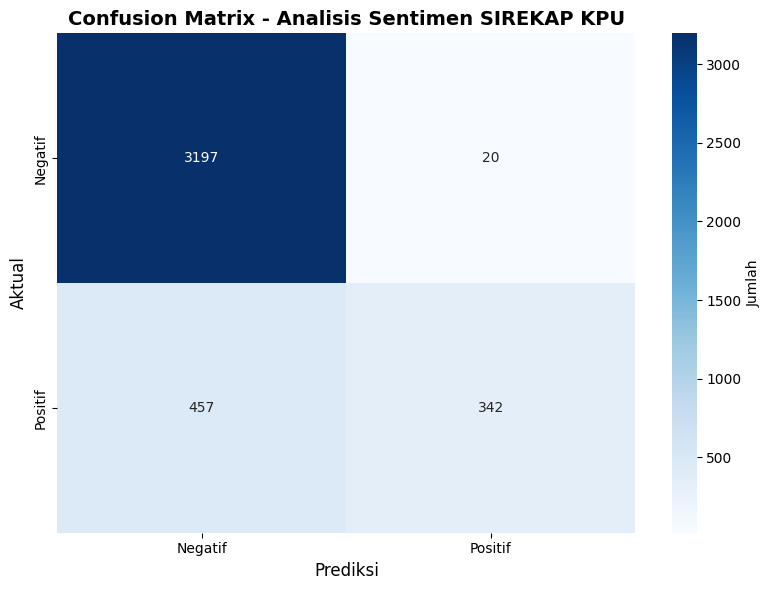


True Negative  : 3197 (Review negatif diprediksi negatif ✓)
False Positive : 20 (Review negatif diprediksi positif ✗)
False Negative : 457 (Review positif diprediksi negatif ✗)
True Positive  : 342 (Review positif diprediksi positif ✓)


In [46]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Hitung confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['Negatif', 'Positif'])

# Visualisasi
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negatif', 'Positif'],
            yticklabels=['Negatif', 'Positif'],
            cbar_kws={'label': 'Jumlah'})
plt.xlabel('Prediksi', fontsize=12)
plt.ylabel('Aktual', fontsize=12)
plt.title('Confusion Matrix - Analisis Sentimen SIREKAP KPU', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Interpretasi hasil
print(f"\nTrue Negative  : {cm[0][0]} (Review negatif diprediksi negatif ✓)")
print(f"False Positive : {cm[0][1]} (Review negatif diprediksi positif ✗)")
print(f"False Negative : {cm[1][0]} (Review positif diprediksi negatif ✗)")
print(f"True Positive  : {cm[1][1]} (Review positif diprediksi positif ✓)")


### Langkah 21: Fungsi Prediksi Review Baru

**Penjelasan:**
Buat fungsi untuk memprediksi sentimen dari review baru. Fungsi ini akan melakukan semua tahap preprocessing (cleaning, stopword removal, stemming) dan menggunakan model yang sudah dilatih untuk prediksi. Output berupa sentimen dan confidence score.

In [47]:
def predict_sentiment(text):
    # Preprocessing
    cleaned = clean_text(text)
    no_stopwords = remove_stopwords(cleaned)
    tokens = word_tokenize(no_stopwords)
    stemmed = [stemmer.stem(word) for word in tokens]
    final_text = ' '.join(stemmed)

    # Vectorization
    text_tfidf = tfidf.transform([final_text])

    # Prediksi
    prediction = model_nb.predict(text_tfidf)[0]
    probability = model_nb.predict_proba(text_tfidf)[0]

    return {
        'text': text,
        'sentiment': prediction,
        'confidence': max(probability) * 100
    }

# Contoh penggunaan
contoh_reviews = [
    "Aplikasi sangat bagus dan membantu sekali!",
    "Jelek banget, sering error dan lambat",
    "Aplikasi lumayan, tapi masih banyak bug yang harus diperbaiki"
]

print("HASIL PREDIKSI:")
print("=" * 70)
for review in contoh_reviews:
    result = predict_sentiment(review)
    print(f"Review: {result['text']}")
    print(f"Sentimen: {result['sentiment']} (Confidence: {result['confidence']:.2f}%)")
    print("-" * 70)


HASIL PREDIKSI:
Review: Aplikasi sangat bagus dan membantu sekali!
Sentimen: Positif (Confidence: 71.55%)
----------------------------------------------------------------------
Review: Jelek banget, sering error dan lambat
Sentimen: Negatif (Confidence: 98.36%)
----------------------------------------------------------------------
Review: Aplikasi lumayan, tapi masih banyak bug yang harus diperbaiki
Sentimen: Negatif (Confidence: 81.25%)
----------------------------------------------------------------------


### Langkah 22: Visualisasi Distribusi Sentimen

**Penjelasan:**
Buat visualisasi untuk melihat distribusi sentimen dalam dataset. Grafik bar chart ini menunjukkan jumlah dan persentase review positif vs negatif, memberikan gambaran umum tentang persepsi pengguna terhadap aplikasi SIREKAP KPU.

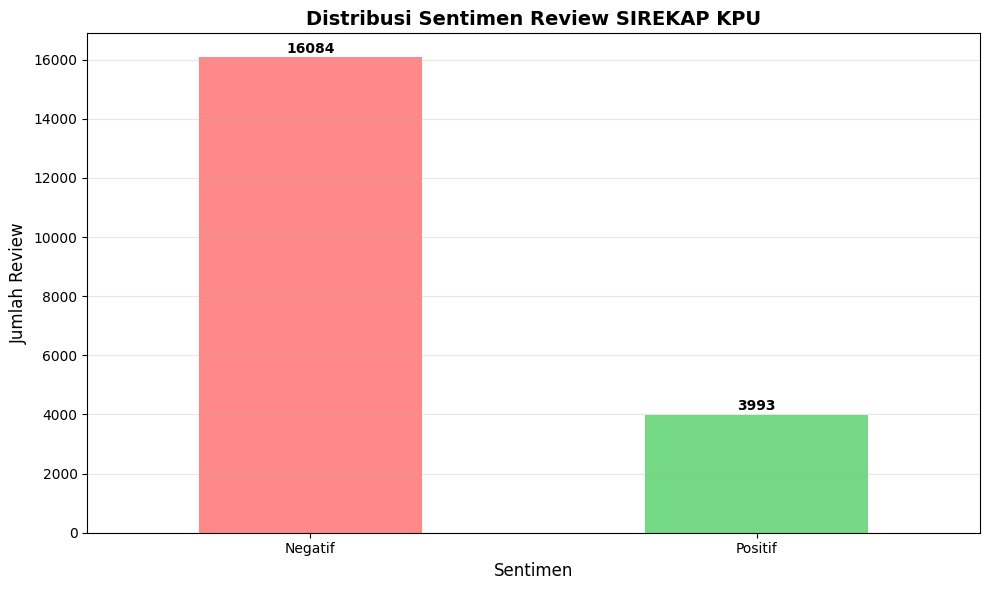


Persentase Sentimen:
Negatif: 16084 review (80.11%)
Positif: 3993 review (19.89%)


In [48]:
# Hitung distribusi sentimen
sentiment_dist = df_clean['Label'].value_counts()

# Visualisasi
plt.figure(figsize=(10, 6))
colors = ['#ff6b6b', '#51cf66']
bars = sentiment_dist.plot(kind='bar', color=colors, alpha=0.8)
plt.title('Distribusi Sentimen Review SIREKAP KPU', fontsize=14, fontweight='bold')
plt.xlabel('Sentimen', fontsize=12)
plt.ylabel('Jumlah Review', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

# Tambahkan nilai di atas bar
for i, v in enumerate(sentiment_dist.values):
    plt.text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Persentase
print("\nPersentase Sentimen:")
for label, count in sentiment_dist.items():
    percentage = (count / len(df_clean)) * 100
    print(f"{label}: {count} review ({percentage:.2f}%)")


### Langkah 23: Word Cloud Sentimen Positif & Negatif

**Penjelasan:**
Word Cloud memvisualisasikan kata-kata yang paling sering muncul dalam review. Ukuran kata menunjukkan frekuensi kemunculannya. Dengan membuat word cloud terpisah untuk sentimen positif dan negatif, kita dapat melihat kata-kata kunci yang menjadi ciri khas masing-masing sentimen.

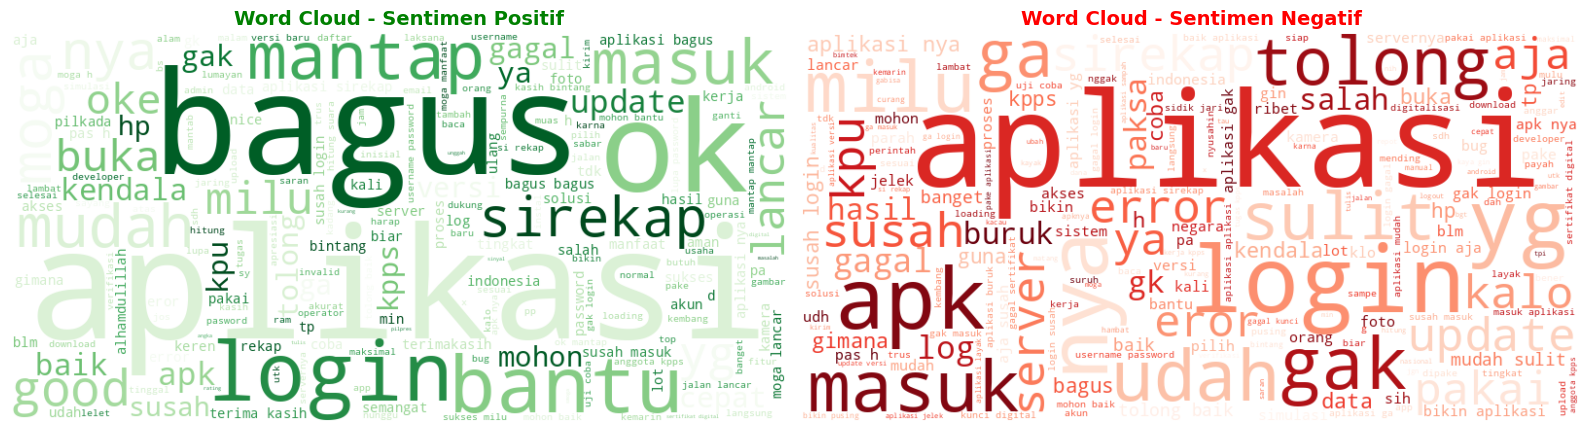

In [49]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Word Cloud untuk Sentimen Positif
text_positif = ' '.join(df_clean[df_clean['Label'] == 'Positif']['text_final'])

wordcloud_pos = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Greens'
).generate(text_positif)

# Word Cloud untuk Sentimen Negatif
text_negatif = ' '.join(df_clean[df_clean['Label'] == 'Negatif']['text_final'])

wordcloud_neg = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Reds'
).generate(text_negatif)

#  Visualisasi Kedua Word Cloud
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Word cloud positif
axes[0].imshow(wordcloud_pos, interpolation='bilinear')
axes[0].set_title(
    'Word Cloud - Sentimen Positif',
    fontsize=14,
    fontweight='bold',
    color='green'
)
axes[0].axis('off')

# Word cloud negatif
axes[1].imshow(wordcloud_neg, interpolation='bilinear')
axes[1].set_title(
    'Word Cloud - Sentimen Negatif',
    fontsize=14,
    fontweight='bold',
    color='red'
)
axes[1].axis('off')

plt.tight_layout()
plt.show()


### Langkah 24: Simpan Model & Vectorizer

**Penjelasan:**
Simpan model yang sudah dilatih dan TF-IDF vectorizer ke file menggunakan pickle. File-file ini dapat digunakan kembali untuk prediksi di masa depan tanpa perlu training ulang. Ini sangat berguna untuk deployment aplikasi atau analisis berkelanjutan.

In [50]:
import pickle

# Simpan model
with open('model_sentiment.pkl', 'wb') as f:
    pickle.dump(model_nb, f)

# Simpan vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

print("✓ Model berhasil disimpan ke 'model_sentiment.pkl'")
print("✓ Vectorizer berhasil disimpan ke 'tfidf_vectorizer.pkl'")


✓ Model berhasil disimpan ke 'model_sentiment.pkl'
✓ Vectorizer berhasil disimpan ke 'tfidf_vectorizer.pkl'


### Langkah 25: Load Model untuk Penggunaan Kembali

**Penjelasan:**
Demonstrasi cara memuat kembali model dan vectorizer yang sudah disimpan. Ini berguna ketika ingin menggunakan model di session baru tanpa perlu training ulang. Setelah dimuat, model dapat langsung digunakan untuk prediksi.

In [52]:
# Load model dan vectorizer
with open('model_sentiment.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

with open('tfidf_vectorizer.pkl', 'rb') as f:
    loaded_tfidf = pickle.load(f)

print("✓ Model dan vectorizer berhasil dimuat!")

# Test prediksi dengan model yang dimuat
test_text = "Aplikasi ini sangat membantu dan mudah digunakan"
test_clean = clean_text(test_text)
test_nostop = remove_stopwords(test_clean)
test_tokens = word_tokenize(test_nostop)
test_stemmed = ' '.join([stemmer.stem(word) for word in test_tokens])
test_tfidf = loaded_tfidf.transform([test_stemmed])
prediction = loaded_model.predict(test_tfidf)[0]

print(f"\nTest Prediksi:")
print(f"Text: {test_text}")
print(f"Prediksi: {prediction}")

✓ Model dan vectorizer berhasil dimuat!

Test Prediksi:
Text: Aplikasi ini sangat membantu dan mudah digunakan
Prediksi: Negatif
